In [2]:
!nvidia-smi

Sat Aug 28 03:31:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |   5371MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
#mobilenet.py
# pytorch mobilenet model train
# by tara kapoor
# for thyroid project, using dicom image files
# feeding in individual images using the thyroid_dataset file
# feed in all images from one patient at once using the code commented out at the bottom of the thyroid_dataset file


import os
import pandas as pd
import numpy
import torch
import glob

import random

import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 

import torch.optim as optim
import argparse
import time

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#from thyroid_dataset import *
from torch.utils.data import DataLoader
#from torchsampler import ImbalancedDatasetSampler
from sklearn.utils import resample

import math

import matplotlib.pyplot as plt
import argparse

import csv
from csv import writer
from csv import reader
import os
from os import path
import operator

import torch.utils.data as data
import torch
import numpy as np

from PIL import Image
import os
import os.path
from torch.utils.data import DataLoader

import argparse
#import pydicom
import random
import h5py
import re
#import skimage
from pathlib import Path
import tables
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from captum.attr import IntegratedGradients

print("done with imports!")

done with imports!


In [4]:
parser = argparse.ArgumentParser(description="Thyroid Project Pytorch Model Code")

parser.add_argument("--batchSize", type=int, default=16, help="Training batch size")
parser.add_argument("--num_classes", type=int, default=2, help="Number of output classes (benign/malignant)")
parser.add_argument("--num_epochs", type=str, default="100", help="how many epochs to train")
parser.add_argument("--best_epoch", type=str, default="99", help="how many epochs to train")
parser.add_argument("--best_thresh", type=float, default=0.0, help="probability threshold from train transformer for benign/malignant prediction")
parser.add_argument("--best_thresh_2tpr", type=float, default=0.0, help="2*tpr weighted probability threshold from train transformer for benign/malignant prediction")
parser.add_argument("--best_thresh_2fpr", type=float, default=0.0, help="2*fpr weighted probability threshold from train transformer for benign/malignant prediction")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--model_dir", type=str, default='_thyroid_weighted_focal_extralinear_3rowstack_trainonly', help="folder to save your trained model")
parser.add_argument("--model_path", type=str, default='', help="actual path to save your trained model")
parser.add_argument("--pretrained_dir", type=str, help="folder to save pretrained model weights for setup_model function")
parser.add_argument("--modeltype", type=str, default='mobilenet', help="type of cnn model running")
parser.add_argument("--phase", type=str, default="train", help="train, val, test, etc")
parser.add_argument("--cvphase", type=int, default=0, help="cross validation fold 0 through 4")
parser.add_argument("--imgpath", type=str, default="/home/jupyter/containers/images/ALL_IMG_Final.hdf5", help="path to img hdf5 file")  #CHANGE if required
parser.add_argument("--maskpath", type=str, default="/home/jupyter/containers/images/ALL_MASK_Final.hdf5", help="path to mask hdf5 file")  #CHANGE if required
parser.add_argument("--labelpath", type=str, default="/home/jupyter/containers/images/frame_lesionId_label_demographics_foldNum.csv", help="path to labels csv file") #CHANGE if required
parser.add_argument("--project_home_dir", type=str, default="/home/jupyter/", help="home project directory") #CHANGE
parser.add_argument("--frametype", type=str, default="singleframe", help="adjacent, equalspaced, singleframe (to feed into model)")
parser.add_argument("--probFunc", type=str, default="Softmax", help="classification function")
parser.add_argument("--weightdecay", type=bool, default=False, help="whether to add weight decay in transformer training")
parser.add_argument("--trainval", type=bool, help="whether in training mode with or without validation data (3/5 or 4/5)")
parser.add_argument("--weighted_sampler", type=bool, default=True)
args = parser.parse_args("")
print(args.phase)

train


In [5]:

args.batchSize = 16
args.lr = 0.001#0.001
save_freq = 4
confocal_project_directory = '/home/jupyter/'#'/share/pi/rubin/tarakap/'
args.num_classes = 2

args.modeltype = 'mobilenet'

args.model_dir = args.modeltype + '_thyroid_weighted_focal_extralinear_'+args.frametype
args.model_path = confocal_project_directory + 'model/' + args.model_dir + '/'
args.pretrained_dir = args.modeltype
args.phase = "train"

#for weights
neg = 0
pos = 0
total_lbls = 0
class_weight = []
samples_weight = []

print("done")



done


In [6]:

def setup_model(net, phase, cvphase, epoch):
    print("setting up model")
    
    args.model_path = confocal_project_directory + 'model/' + args.model_dir + '/'
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
        print('Make the folder', args.model_path, 'to save model---------\n')
    if (phase == 'test'):# or continue_train):
        load_path = confocal_project_directory + 'model/' + args.pretrained_dir + '/' + args.pretrained_dir +'_cv%s_epoch%s.pth' % (cvphase, epoch)#'_%s.pth' % epoch
        
        print('loading the model from %s' % load_path)
        
        #for cnn
        pretrained_state_dict = torch.load(load_path, map_location=str(device))
        
        try:
            net.load_state_dict(pretrained_state_dict)
            print("successfully loaded pretrained state dict")
            #load the weights from the trained model to use in test phase?
        except:
            try:
                model_dict = net.state_dict()
                
                #print("pretrained:")
               # for key, value in pretrained_state_dict.items() :
               #     print(key)
               # print("model:")
              #  for key, value in model_dict.items() :
               #     print(key)
                pretrained_state_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
                net.load_state_dict(pretrained_state_dict)
            except:
                print(
                    'Pretrained network has fewer layers; The following are not initialized:')
                for k, v in pretrained_state_dict.items():
                    if v.size() == model_dict[k].size():
                        model_dict[k] = v

                not_initialized = set()
                for k, v in model_dict.items():
                    if k not in pretrained_state_dict or v.size() != pretrained_state_dict[k].size():
                        not_initialized.add(k.split('.')[0])

                print(sorted(not_initialized))
                net.load_state_dict(model_dict)


def save_networks(net, epoch, cvphase):
    save_path = args.model_path
    save_file_name = save_path + args.model_dir + '_cv%s_epoch%s.pth' % (cvphase, epoch)
    print("model save path:", save_file_name)
    torch.save(net.state_dict(), save_file_name)

In [7]:
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!conda install -c conda-forge imgaug -y
#!conda install -c conda-forge albumentations -y
import albumentations as A

In [8]:
#thyroid dataset
print("\nTHYROID DATASET\n")
import torch.utils.data as data
import torch
import numpy as np

from PIL import Image
import os
import os.path
from torch.utils.data import DataLoader

import argparse
#import pydicom
import random
import h5py
import re
#import skimage
from pathlib import Path
import tables
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#crop around bounding box of mask
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def crop_bounding_box(img, mask):
    info = np.iinfo(mask.dtype)

    ret,thresh = cv2.threshold(mask, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    cnt = contours[0]

    #find coordinates to crop
    (y, x) = np.where(thresh == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))

    out = img[topy-5:bottomy+5, topx-5:bottomx+5] #5 pixel border
    return out


def transform_and_crop_new(imgs, masks):
    all_imgs_cropped=[]
    #cropping approach by mask (crop before resizing):
    #trying cropping as cv image
    for im in range(len(imgs)):
        cv_im = imgs[im]
        mask = masks[im]
        cropped_im = crop_bounding_box(cv_im, mask) #needs 3 channels

        #downsize images with PIL 
        cropped_im = np.asarray(cropped_im)
        new_im = Image.fromarray(cropped_im) #convert to PIL format Image
        new_im = new_im.resize((224, 224)) #resize with PIL
        
        all_imgs_cropped.append(np.array(new_im))
    
    print("all images array shape after cropping/resizing:", np.shape(all_imgs_cropped))
    return all_imgs_cropped


#for singleframe
def transform_and_crop_largest(imgs, masks,pats):
    all_imgs_cropped=[]
    newpats = []
    biggestinpat = np.zeros((len(imgs)))
    firstinpat = False
    patmaxarea = 0
    patmaxareaind = 0
    
    pats.pop(0) #take out title row
    
    #cropping approach by mask (crop before resizing):
    for im in range(len(imgs)):
        if(pats[im] not in newpats):
            newpats.append(pats[im])
            firstinpat = True
            if(len(newpats) > 1):
                biggestinpat[patmaxareaind] = 1
                print("last patient", pats[im-1], "(check)", pats[patmaxareaind], "max area", patmaxarea, "at ind", patmaxareaind)
            patmaxarea = 0
            patmaxareaind = 0
        else:
            firstinpat = False
        
        cv_im = imgs[im]
        mask = masks[im]
        cropped_im = crop_bounding_box(cv_im, mask) #needs 3 channels
        
        #downsize images with PIL 
        cropped_im = np.asarray(cropped_im)
        new_im = Image.fromarray(cropped_im) #convert to PIL format Image
        
        #lesion area
        w, h = new_im.size
        if(w*h >= patmaxarea): #if largest, update patientmaxarea variables
            patmaxareaind = im
            patmaxarea = w*h
            #print("in patient", pats[im], "biggest area so far", patmaxarea,"index", im)
        
        new_im = new_im.resize((224, 224)) #resize with PIL
        
        if(im == 0):
            print("after resize")
            imgplot = plt.imshow(new_im)
            plt.show() #show cropped and resized image
        if(im%1000 == 0):
            print(im)
        
        all_imgs_cropped.append(np.array(new_im))
        
    #do last patient
    biggestinpat[patmaxareaind] = 1
    print(len(newpats), "total pats:", newpats)
    
    print("all images array shape after cropping/resizing:", np.shape(all_imgs_cropped))
    return all_imgs_cropped, biggestinpat

print("done")


THYROID DATASET

done


In [9]:
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch import ToTensor

#TRANSFORMATIONS:
#TRANSFORM for data augmentation defining here
# transformAug = A.Compose([
#     #A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.9),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
#     #A.RandomContrast(limit=0.2, p=1.0),
#     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, p=0.98),
#     #A.Cutout(num_holes=2, max_h_size=int(0.4*image_size), max_w_size=int(0.4*image_size), fill_value=0, always_apply=True, p=1.0),
#     A.Normalize(mean=(0.456, 0.456, 0.456), std=(0.224, 0.224, 0.224), max_pixel_value=255.0, p=1.0)   
# ])

    
#albumentations
transformAug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    #A.RandomContrast(limit=0.2, p=1.0),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, p=0.4),
    A.Cutout(num_holes=2, max_h_size=int(0.25*224), max_w_size=int(0.25*224), fill_value=0, always_apply=True, p=0.9),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

#broken
transformNorm = A.Compose([
    #transforms.Compose([#transforms.ToPILImage(),
    #new_transforms.Resize((imgSize,imgSize)),
    #transforms.ToTensor(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


#TOTENSOR IS RESHAPING
# takes pil or numpy array of shape (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)
#need to reshape dfrom [3,224,224] to [224, 224, 3] which is (1, 2, 0) in getitem??

#color jitter: brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1

#good
augment = transforms.Compose([transforms.ToPILImage(), #convert to pil image
                              #transforms.Resize((224,224)),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(degrees=30),
                              transforms.ColorJitter(0.2, 0.2, 0.2, 0.05), #ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.05, 0.05])
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

transform = transforms.Compose([transforms.ToPILImage(),
                                #transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



after resize


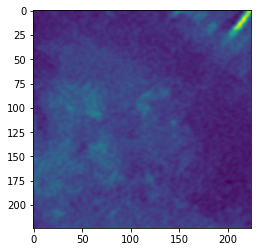

0
last patient 129_ (check) 129_ max area 218560 at ind 83
last patient 130_ (check) 130_ max area 185472 at ind 168
last patient 197_ (check) 197_ max area 200000 at ind 222
last patient 202_ (check) 202_ max area 92512 at ind 308
last patient 66_ (check) 66_ max area 125829 at ind 396
last patient 159_ (check) 159_ max area 210210 at ind 458
last patient 155_ (check) 155_ max area 192192 at ind 530
last patient 87_ (check) 87_ max area 44100 at ind 604
last patient 60_ (check) 60_ max area 63525 at ind 740
1000
last patient 148_ (check) 148_ max area 24640 at ind 1187
last patient 99_ (check) 99_ max area 153792 at ind 1348
last patient 74_ (check) 74_ max area 101574 at ind 1379
last patient 190_ (check) 190_ max area 136097 at ind 1431
last patient 18_ (check) 18_ max area 32890 at ind 1573
last patient 81_ (check) 81_ max area 36480 at ind 1644
last patient 22_ (check) 22_ max area 56635 at ind 1762
last patient 50_ (check) 50_ max area 322500 at ind 1899
2000
last patient 4_ (che

In [10]:

#imgs = transform_and_crop_new(h5py.File('/home/jupyter/containers/images/ALL_IMG_Final.hdf5')['img'], h5py.File('/home/jupyter/containers/images/ALL_MASK_Final.hdf5')['img'])
colnames = ['Labels for each frame', 'Annot_IDs', 'size_A', 'size_B', 'size_C', 'location_r_l_', 'study_dttm', 'age', 'sex', 'final_diagnoses', 'ePAD ID', 'foldNum']
imgs, largestpatinds = transform_and_crop_largest(h5py.File(args.imgpath)['img'], h5py.File(args.maskpath)['img'], pd.read_csv(args.labelpath, names=colnames).Annot_IDs.tolist())


In [11]:
def load_datasets_new(phase, cv_phase, allimgs, frametype):
    print("passed in list allimgs:", np.shape(allimgs))
    
    colnames = ['Labels for each frame', 'Annot_IDs', 'size_A', 'size_B', 'size_C', 'location_r_l_', 'study_dttm', 'age', 'sex', 'final_diagnoses', 'ePAD ID', 'foldNum']
    label_data = pd.read_csv(args.labelpath, names=colnames)
    
    annot_ids = label_data.Annot_IDs.tolist() #list of annotation ids from csv file
    labels = label_data.final_diagnoses.tolist() #list of labels from csv file
    
    foldNums = label_data.foldNum.tolist() #list of what folder for train test split
    
    annot_ids.pop(0)
    labels.pop(0)
    foldNums.pop(0)
    
    correct_order_labels = []
    
    for i in range(len(allimgs)):
        correct_order_labels.append(labels[i])
    
    print('Num Images: {}\n Labels: {}\n'.format(len(allimgs), len(correct_order_labels), len(annot_ids)))
    cur_imgs = []
    cur_labels = []
    cur_annot_ids = []

    test_folder = cv_phase #0, 1, 2, 3, 4
    if(cv_phase < 4):
        val_folder = cv_phase+1
    elif(cv_phase == 4):
        val_folder = 0
    
    print("CROSS VALIDATION PHASE:", test_folder)
    #split by foldnum group
    for g in range(len(allimgs)):
        fnum = int(foldNums[g])
        
        if (phase == "train"):
            if not (fnum == test_folder or fnum == val_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        elif (phase == "val"):
            if (fnum == val_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        elif (phase == "trainval"):
            if not (fnum == test_folder): #train and val images
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        #else: #test phase
        elif (phase == "test"):
            if (fnum == test_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        
    
    #label frame number of each image
    cur_frame_num = []
    distinct_patient_ids = []
    patientframenum = 0

    #if 3 images in a row from same patient, stack them (instead of rgb channels)
    for ind in range(len(cur_imgs)):
        if(not (cur_annot_ids[ind] in distinct_patient_ids)):
            #if(not (ind == 0)):
                #print(cur_annot_ids[ind-1], "patient has", patientframenum-1, "frames")
            distinct_patient_ids.append(cur_annot_ids[ind])
            patientframenum = 1
        cur_frame_num.append(patientframenum) #add index of first image in current frame stack within patient to list for order
        patientframenum += 1
    #print(distinct_patient_ids[len(distinct_patient_ids)-1], "patient has", patientframenum-1, "frames")
    print(len(cur_imgs), len(cur_labels), len(cur_annot_ids), len(cur_frame_num))

    
    #stack:
    cur_imgs_stack = []
    cur_labels_stack = []
    cur_annot_ids_stack = []
    cur_frame_num_stack = []
    
    distinct_patient_ids = []
    dist = 10
    #for t in range(0, len(train_imgs) - 3, 3): #intervals of 3
    t = 0
    
    print("about to stack!")
    
    if(frametype == "adjacent"):
        #if 3 images in a row from same patient, stack them (instead of rgb channels)
        while (t < len(cur_imgs)-2):
            if(cur_annot_ids[t] not in distinct_patient_ids):
                distinct_patient_ids.append(cur_annot_ids[t])
            if(cur_annot_ids[t] == cur_annot_ids[t+1] and cur_annot_ids[t] == cur_annot_ids[t+2]):
                #img = np.stack((train_imgs[t], train_imgs[t+1], train_imgs[t+2]))
                img = np.stack((cur_imgs[t], cur_imgs[t+1], cur_imgs[t+2]))
                cur_imgs_stack.append(img)
                cur_labels_stack.append(cur_labels[t])
                cur_annot_ids_stack.append(cur_annot_ids[t])
                cur_frame_num_stack.append(cur_frame_num[t]) #add index of first image in current frame stack within patient to list for order
                if(cur_labels[t] != cur_labels[t+1] or cur_labels[t] != cur_labels[t+2]):
                    print("inconsistent labels in train group of 3 images!")
            t += 3 #everyone needs t + 1 to go to next frame   
   
    else:
        #EQUAL SPACED method
        while (t < len(cur_imgs) - (2*dist)):
            if(cur_annot_ids[t] not in distinct_patient_ids):
                annot_id = cur_annot_ids[t]
                #last index of this patient id in the list of ids
                last_id = len(cur_annot_ids) - cur_annot_ids[::-1].index(annot_id) - 1
                #print("num in this patient", last_id - t)
                dist = (last_id - t) // 3
                distinct_patient_ids.append(cur_annot_ids[t])
                print("PATIENT", cur_annot_ids[t], "num frames:", last_id-t)

            #if 3 images equally spaced from same patient, stack them (instead of rgb channels)
            if(t <= (last_id - (2*dist))):
                if(cur_annot_ids[t] == cur_annot_ids[t+dist] and cur_annot_ids[t] == cur_annot_ids[t+(2*dist)]):
                    img = np.stack((cur_imgs[t], cur_imgs[t+dist], cur_imgs[t+(2*dist)]))
                    cur_imgs_stack.append(img)
                    cur_labels_stack.append(cur_labels[t])
                    cur_annot_ids_stack.append(cur_annot_ids[t])

                    cur_frame_num_stack.append(cur_frame_num[t]) #add index of first image in current frame stack within patient to list for order

                    #if(train_labels[t] != train_labels[t+1] or train_labels[t] != train_labels[t+2]):
                    if(cur_labels[t] != cur_labels[t+dist] or cur_labels[t] != cur_labels[t+(2*dist)]):
                        print("inconsistent labels in train group of 3 images!")
                        print("t:", t, "dist:", dist, "last id", last_id, "cur labels:", cur_labels[t], cur_annot_ids[t], cur_labels[t+(2*dist)], cur_annot_ids[t+(2*dist)])
            else: #end of patient?
                g = 0
                if(cur_annot_ids[t] != cur_annot_ids[t + (2*dist) + 1]):
                    t += (2*dist)#go to next patient!
                else:
                    print("not at end of patient?")
                    while(cur_annot_ids[t] == cur_annot_ids[t + (2*dist) + 1 + g]):
                        g += 1
                    print("final difference:", g)
                    t += (2*dist) + g
            t += 1 #everyone needs t + 1 to go to next frame
            
    print("\n\nnum patients:", len(distinct_patient_ids))
    print("done stacking!")
    #shuffle all lists with same order for TRAIN ONLY
    if (phase == 'train' or phase == 'trainval'):# or phase == 'test'):
        temp = list(zip(cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num_stack)) 
        random.shuffle(temp) 
        cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num_stack = zip(*temp)
    
    if (phase == 'train' or phase == 'trainval'):
        #for class weights (imbalance of classes)
        neg, pos = np.bincount(cur_labels_stack)#intlabels)
        print("0s", neg, "1s", pos)
        total_lbls = neg + pos
        print(total_lbls == len(cur_labels_stack))
        print('Labels:\n Total: {}\n Positive: {} ({:.2f}% of total)\n'.format(total_lbls, pos, 100 * pos / total_lbls))

        #https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg)*(total_lbls)/2.0 
        weight_for_1 = (1 / pos)*(total_lbls)/2.0

        #class_weight = {0: weight_for_0, 1: weight_for_1}
        class_weight = [weight_for_0, weight_for_1]
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
        samples_weight = []
        samples_weight = np.array([class_weight[int(m)] for m in cur_labels_stack])
        print("in train phase for load_dataset: samples_weight shape =", np.shape(samples_weight))
        
        f=open(args.project_home_dir + "samplesweight.csv",'w', newline ='\n')
        count = 0
        for s in zip(samples_weight):
            if(count%500 == 0):
                print(s, s[0])
            count += 1
            f.write(str(s[0])+",")
        f.close()
        
    #done preprocessing!
    print("len", phase, "=", len(cur_imgs))
    print("len", phase, "(stacked)", len(cur_imgs_stack), len(cur_labels_stack), len(cur_annot_ids_stack), len(cur_frame_num_stack), np.shape(cur_imgs_stack))
    return(cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num_stack) #return train/test imgs and labels and frame index #s



#only max area frame +- 1 frame from each patient
def load_datasets_single_frame(phase, cv_phase, allimgs, largestpatinds):     
    print("passed in list allimgs:", np.shape(allimgs))
    
    colnames = ['Labels for each frame', 'Annot_IDs', 'size_A', 'size_B', 'size_C', 'location_r_l_', 'study_dttm', 'age', 'sex', 'final_diagnoses', 'ePAD ID', 'foldNum']
    label_data = pd.read_csv(args.labelpath, names=colnames)
    
    annot_ids = label_data.Annot_IDs.tolist() #list of annotation ids from csv file
    labels = label_data.final_diagnoses.tolist() #list of labels from csv file
    
    foldNums = label_data.foldNum.tolist() #list of what folder for train test split
    
    annot_ids.pop(0)
    labels.pop(0)
    foldNums.pop(0)
    
    correct_order_labels = []
    
    selannotids = []
    selimgs = []
    selfoldnums = []

    #only use largest in patient
    for i in range(len(allimgs)-1):
        img1 = 0
        img2 = 0
        img3 = 0
        #if((largestpatinds[i] == 1 or largestpatinds[i+1] == 1 or largestpatinds[i-1] == 1): #largest, and before and after (3 per patient)
        if(i>0 and (annot_ids[i] != annot_ids[i-1])):
            print("patient status:", annot_ids[i-1], annot_ids[i], annot_ids[i+1], "largest", largestpatinds[i-1], largestpatinds[i], largestpatinds[i+1])    
        if(largestpatinds[i] == 1): #largest, and before and after (3 per patient)
            img1 = allimgs[i-1]
            img2 = allimgs[i]
            img3 = allimgs[i+1]
            if(annot_ids[i] != annot_ids[i-1]):
                print("patient", annot_ids[i], "first img = largest")
                img1 = img2
            if(annot_ids[i] != annot_ids[i+1]):
                print("patient", annot_ids[i], "last img = largest")
                img3 = img2
            correct_order_labels.append(labels[i])
            correct_order_labels.append(labels[i])
            correct_order_labels.append(labels[i])
            selannotids.append(annot_ids[i])
            selannotids.append(annot_ids[i])
            selannotids.append(annot_ids[i])
            selimgs.append(img1)
            selimgs.append(img2)
            selimgs.append(img3)
            selfoldnums.append(foldNums[i])
            selfoldnums.append(foldNums[i])
            selfoldnums.append(foldNums[i])
    
    print('Num TOTAL Images: {}\n patients: {}\n'.format(len(allimgs), len(annot_ids)))
    print('Num SELECTED (max) Images: {}\n Labels: {}\n Patients: {}\n'.format(len(selimgs), len(correct_order_labels), len(selannotids)))
    
    allimgs = selimgs
    annot_ids = selannotids
    foldNums = selfoldnums
    
    cur_imgs = []
    cur_labels = []
    cur_annot_ids = []

    test_folder = cv_phase #0, 1, 2, 3, 4
    if(cv_phase < 4):
        val_folder = cv_phase+1
    elif(cv_phase == 4):
        val_folder = 0
    
    print("CROSS VALIDATION PHASE:", test_folder)
    #split by foldnum group
    for g in range(len(allimgs)):
        fnum = int(foldNums[g])
        
        if (phase == "train"):
            if not (fnum == test_folder or fnum == val_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        elif (phase == "val"):
            if (fnum == val_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        elif (phase == "trainval"):
            if not (fnum == test_folder): #train and val images
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        #else: #test phase
        elif (phase == "test"):
            if (fnum == test_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        
    #stack:
    cur_imgs_stack = []
    cur_labels_stack = []
    cur_annot_ids_stack = []
    #label frame number of each image
    cur_frame_num = []
    
    distinct_patient_ids = []
    t = 0
    patientframenum = 1
    
    print("about to stack!")
    #for t in range(len(cur_imgs)):
    while t < len(cur_imgs):
        if(cur_annot_ids[t] not in distinct_patient_ids):
            annot_id = cur_annot_ids[t]
            distinct_patient_ids.append(cur_annot_ids[t])
            patientframenum = 1
        print("PATIENTS", cur_annot_ids[t], cur_annot_ids[t+1], cur_annot_ids[t+2])
        
        if (not (cur_annot_ids[t] == cur_annot_ids[t+1] and cur_annot_ids[t] == cur_annot_ids[t+2])):
            print("ERROR ERROR UNMATCHING PATIENTS", cur_annot_ids[t], cur_annot_ids[t+1], cur_annot_ids[t+2])
        #img = np.stack((cur_imgs[t], cur_imgs[t+1], cur_imgs[t+2]))
        #INSTEAD DO SAME IMAGE X3, ONLY LARGEST
        img = np.stack((cur_imgs[t+1], cur_imgs[t+1], cur_imgs[t+1]))
        cur_imgs_stack.append(img)
        cur_labels_stack.append(cur_labels[t+1])
        cur_annot_ids_stack.append(cur_annot_ids[t+1])
        cur_frame_num.append(patientframenum) #add index of first image in current frame stack within patient to list for order
        patientframenum += 1
        t += 3

    print("done stacking!")
    #shuffle all lists with same order for TRAIN ONLY
    if (phase == 'train' or phase == 'trainval'):
        temp = list(zip(cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack)) 
        random.shuffle(temp) 
        cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack = zip(*temp)
    
    if (phase == 'train' or phase == 'trainval'):
        #for class weights (imbalance of classes)
        neg, pos = np.bincount(cur_labels_stack)
        print("0s", neg, "1s", pos)
        total_lbls = neg + pos
        print(total_lbls == len(cur_labels_stack))
        print('Labels:\n Total: {}\n Positive: {} ({:.2f}% of total)\n'.format(total_lbls, pos, 100 * pos / total_lbls))
        #https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg)*(total_lbls)/2.0 
        weight_for_1 = (1 / pos)*(total_lbls)/2.0

        class_weight = [weight_for_0, weight_for_1]
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
        samples_weight = []
        samples_weight = np.array([class_weight[int(m)] for m in cur_labels_stack])
        print("in train phase for load_dataset: samples_weight shape =", np.shape(samples_weight))
        f=open(args.project_home_dir + "samplesweight.csv",'w', newline ='\n')
        count = 0
        for s in zip(samples_weight):
            if(count%500 == 0):
                print(s, s[0])
            count += 1
            f.write(str(s[0])+",")
        f.close()
        
    #done preprocessing!
    print("len", phase, "=", len(cur_imgs))
    print("len", phase, "stacked =", len(cur_imgs_stack))
    print("len", phase, "(stacked)", len(cur_imgs_stack), len(cur_labels_stack), len(cur_annot_ids_stack), np.shape(cur_imgs_stack), len(cur_frame_num))
    return(cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num) #return train/test imgs and labels and frame index #s



class DatasetThyroid3StackedNew(data.Dataset):
    #def __init__(self, phase, cvphase, frametype, transform=None):
    def __init__(self, phase, cvphase, frametype, imgs, largestpatinds, transform=None):
        super(DatasetThyroid3StackedNew, self).__init__()
        
        h5py.File(args.imgpath).keys()
        #colnames = ['Labels for each frame', 'Annot_IDs', 'size_A', 'size_B', 'size_C', 'location_r_l_', 'study_dttm', 'age', 'sex', 'final_diagnoses', 'ePAD ID', 'foldNum']
        #imgs, largestpatinds = transform_and_crop_largest(h5py.File(args.imgpath)['img'], h5py.File(args.maskpath)['img'], pd.read_csv(args.labelpath, names=colnames).Annot_IDs.tolist())

        self.phase = phase
        
        print("frametype", frametype)
        if(frametype == "singleframe"):
            self.imgs, self.all_labels, self.all_annot_ids, self.all_frame_nums = load_datasets_single_frame(phase, cvphase, imgs, largestpatinds)
        if(frametype == "adjacent" or frametype == "equalspaced"):
            self.imgs, self.all_labels, self.all_annot_ids, self.all_frame_nums = load_datasets_new(phase, cvphase, imgs, frametype)
        print("done reading in images and labels for", phase, "!!!\n\n")
    
        imgs = []
    
        self.transform = transform
        print("all frames:", len(self.imgs), np.shape(self.imgs))


    
    #getitem is called 'batch_size' number of times in one iteration of the epoch
    def __getitem__(self, i):
        img_frame = self.imgs[i] #3 stacked frames (rgb) from same patient OR same image x3
        annot_id = self.all_annot_ids[i]
        frame_num = self.all_frame_nums[i]
        
        #create label for image
        label = torch.LongTensor(1)
        label[0] = int(self.all_labels[i])

        if(self.transform):
            #make height, width, channels instead of [3,224,224] which is channels, height, width
            img_frame = np.transpose(img_frame, (1,2,0)).astype(np.float32)
            input1 = self.transform(image=img_frame)['image']
        else:
            #doing this in albumentations transform
            input1 = torch.from_numpy(img_frame).float()
        return {'input': input1, 'label': label, 'annot_id': annot_id, 'frame_num': frame_num}

    def __len__(self):
        return len(self.all_annot_ids)

In [24]:


def focal_loss(bce_loss, targets, gamma, alpha):
    """Binary focal loss, mean. Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with improvements for alpha.
     :param bce_loss: Binary Cross Entropy loss, a torch tensor.
     :param targets: a torch tensor containing the ground truth, 0s and 1s.
     :param gamma: focal loss power parameter, a float scalar.
     :param alpha: weight of the class indicated by 1, a float scalar."""
    p_t = torch.exp(-bce_loss)
    
    #L=−αt(1−pt)γlog(pt)
    
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1) #alpha if target = 1 and 1 - alpha if target = 0
    
    
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()


def roc_auc_score_FIXED(y_true, y_pred):
    if (len(np.unique(y_true)) == 1): # bug in roc_auc_score
        return accuracy_score(y_true, np.rint(y_pred))
    return roc_auc_score(y_true, y_pred)


#temperature scaling for model output calibration
def T_scaling(logits, temperature):
    temperature = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
    return logits / temperature

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [25]:

###############
print("torchvision version:", torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


torchvision version: 0.7.0


In [26]:
# ---- start train ---------

args.best_thresh = 0.0
args.best_thresh_2tpr = 0.0
args.best_thresh_2fpr = 0.0

#max epochs
args.num_epochs = 100

#ifdefs
args.weighted_sampler = True
args.probFunc = 'Softmax' #or 'Sigmoid'
args.weightdecay = False#True
args.best_epoch = 0



In [235]:
import torch.nn.functional as F
import shap

test_all_labels = []
test_all_probs_ones = []
test_all_patients = []
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    TokenReferenceBase,
    configure_interpretable_embedding_layer,
    remove_interpretable_embedding_layer,
    visualization
)
    
def test_model(min_epoch, layer):
    ttotal = 0
    tcorrect = 0    
    
    if(args.modeltype == "mobilenet"):
        tmodel = models.mobilenet_v2(pretrained=True)
        
    #print(tmodel.features[layer])
    args.phase = "test"
    print(min_epoch)

    #make sure using trainval model
    args.model_dir = args.modeltype + '_thyroid_weighted_focal_extralinear_adj'#+args.frametype
    args.model_path = confocal_project_directory + 'model/' + args.model_dir + '/'
    
    print("pretrained dir:", args.model_dir)
    args.pretrained_dir = args.model_dir

    for param in tmodel.parameters():
        param.requires_grad = False

    #modify actual last linear layer in the mobilenet
    tmodel.classifier._modules['1'] = nn.Linear(1280, 256)
    tmodel.classifier._modules['2'] = nn.Linear(256, 2)
    
    #moves to gpu
    tmodel = tmodel.to(device)
    setup_model(tmodel, "test", args.cvphase, min_epoch)

    test_set_loader = DataLoader(dataset=test_set, num_workers=0, batch_size=args.batchSize, shuffle=False)

    test_all_labels = []
    test_all_probs_ones = []
    test_all_patients = []

    total = 0
    correct = 0

    tmodel.eval() #test mode

    #with torch.no_grad():
    for i, data in enumerate(test_set_loader):
#            inputs = data['input']
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        annot_ids = data['annot_id']

        # Forward pass only to get logits/output
        outputs = tmodel(inputs)
        labels = labels.squeeze()

        default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0, '#ffffff'),
                                              (0.25, '#252b36'),
                                              (1, '#000000')], N=256)

        if(labels[0] == 1):
            #print("inputs shape", np.shape(inputs))
            image = inputs[0].unsqueeze(0)     
    #             scores = tmodel(image) # get the raw scores
    #             pprobs = F.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores

    #             pprobs, idx = pprobs.sort(0, True) # sort the probability distribution in descending order, and idx[0] is the predicted class

    #             feature_maps = tmodel.features(image) # get the feature maps of the last convolutional layer
    #             print('feature_maps.shape: ', feature_maps.detach().cpu().numpy().shape)

            #shap CAM maps
            print("starting shap")
            #explainer = shap.Explainer(tmodel)

            #print(tmodel.features[layer])
            inputs.requires_grad = True
            #print("classifier", tmodel.classifier.features['1'])
            e = shap.GradientExplainer((tmodel, tmodel.features[layer]), inputs)
            #e = shap.GradientExplainer((tmodel, tmodel.features[18]), inputs[0].unsqueeze(0))
            shap_values, indexes = e.shap_values(inputs, ranked_outputs=2, nsamples=200)
            #shap_values, indexes = e.shap_values(inputs[0].unsqueeze(0), ranked_outputs=2, nsamples=200)

            # plot the explanations
            shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

            class_names = {'0': ['no 1', 'benign'], '1': ['no 2', 'malignant']}
            index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes.cpu().numpy())

            #image = inputs[0].reshape((3, 224, 224)).cpu().numpy().transpose((1, 2, 0)) 
            images = (inputs.detach()).reshape((len(inputs), 3, 224, 224)).cpu().numpy().transpose((0, 2, 3, 1)) 
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            for image in range(len(images)):
                images[image] = images[image] * std + mean
                images[image] = np.clip(images[image], 0, 1)

            #apply sigmoid or softmax
            if (args.probFunc == 'Softmax'):
                sf = nn.Softmax(dim=1) #makes items in a row add to 1; dim = 0 makes items in a column add to 1
                outputs = sf(outputs)
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs, 1)
            #add labels + predictions to full set for auroc later
            if torch.cuda.is_available():
                outs_ones = outputs.detach().cpu().numpy()[:, 1]
                labelsnp = labels.cpu().numpy()
            else:
                outs_ones = outputs.detach().numpy()[:, 1]
                labelsnp = labels.numpy()

            """   
            labelledoutputs = [[]]
            doutputs = (outputs.detach().cpu().numpy()).astype('str_')
            for outt in range(len(doutputs)):
                doutputs[outt][0] = "benign: " + doutputs[outt][0]
                doutputs[outt][1] = "malignant: " + doutputs[outt][1]
                if outt == 0:
                    print(doutputs[outt])"""

            print('\n\ntrue class:', labels[0].cpu().numpy(), '    patient', annot_ids[0])
            print('predicted probabilities', outs_ones)#idx[0].cpu().numpy())
            #print("index_names", np.shape(index_names), "shap_values", np.shape(shap_values), np.shape(images))
            #shap.image_plot(shap_values, images, doutputs)

    #         for ddd in range(len(outs_ones)):
    #             print('true class: ', labels[ddd], 'predicted probability:', outs_ones[ddd])
    #             shap.image_plot(shap_values[ddd], images[ddd], index_names[ddd])

            
        
            """for ddd in range(len(shap_values[0])):
                print('true class: ', labels[0], 'patient', annot_ids[0])
                print('predicted probability:', outs_ones[ddd])
                fig = plt.figure()
                ax = fig.add_subplot(1, 2, 1)
                ax.set_title('benign')
                plt.imshow(shap_values[0][ddd])
                plt.colorbar()
                ax = fig.add_subplot(1, 2, 2)
                ax.set_title('malignant')
                plt.imshow(shap_values[1][ddd])
                #plt.colorbar()
                plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
                
                shap.image_plot(shap_values[:, ddd, :, :, :], images[ddd], index_names[ddd]) #works
                
                #shap.image_plot(shap_values, inputs.detach().cpu().numpy().astype('float'), index_names)
                #shap.image_plot(shap_values, inputs.detach().cpu().numpy().astype('float'), index_names)
                # index_names = np.array(['MSS', 'MSI'])"""
            
            shap.image_plot(shap_values, images, index_names) #works
                      
            #fname = "cam_cv" + str(args.cvphase) + "_patient" + str(annot_ids[0]) + "_label" + str(labels[0]) + "_pred{0:.9f}".format(sum(outs_ones)/(len(outs_ones))) + "_layer" +str(layer)+".png"
           # print(fname)
            
          #  shap.image_plot(shap_values, images, index_names).savefig(fname,format = "png",dpi = 150,bbox_inches = 'tight')
#            plt.savefig(fname)
            

        """ #commented out code for CAM heatmap with openCV
        #cam
        params = list(tmodel.classifier._modules['1'].parameters())
        weight = np.squeeze(params[0].data.cpu().numpy())
        #print('weight.shape', weight.shape)
        
        if(labels[0] == 1):
            #for inp in range(len(inputs)):
            inp = 0
            image = inputs[inp].unsqueeze(0)
            scores = tmodel(image) # get the raw scores
            pprobs = F.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores
            print('sum of probabilities: %.0f' % torch.sum(pprobs).cpu().numpy())
            print('true class: ', labels[inp], 'patient', annot_ids[inp])
            print('predicted probability:', pprobs.cpu().numpy())#idx[0].cpu().numpy())
            pprobs, idx = pprobs.sort(0, True) # sort the probability distribution in descending order, and idx[0] is the predicted class

            feature_maps = tmodel.features(image) # get the feature maps of the last convolutional layer
            print('feature_maps.shape: ', feature_maps.detach().cpu().numpy().shape)

            CAMs = return_CAM(feature_maps.detach().cpu().numpy(), weight, [idx.cpu().numpy()[0]]) # generate the CAM for the input image
            heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET)


            print('original image shape: ', inputs[inp].reshape((3, 224, 224)).cpu().numpy().transpose((1,2,0)).shape)
            print('heatmap.shape:', heatmap.shape)
            image = inputs[inp].reshape((3, 224, 224)).cpu().numpy().transpose((1, 2, 0)) 
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = image * std + mean
            image = np.clip(image, 0, 1)

            plt.imshow(image)
            plt.show()
            plt.imshow(heatmap)
            plt.show()

            result = 0.5 * heatmap + 0.5 * image
            cv2.imwrite('cam.png', result)

            heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #low = blue, high = red?
            merged= heatmap * 0.4 + image
            #plt.imshow(merged)
            #cv2.imwrite('cam.png', result)
        """


        #apply sigmoid or softmax
        if (args.probFunc == 'Softmax'):
            sf = nn.Softmax(dim=1) #makes items in a row add to 1; dim = 0 makes items in a column add to 1
            outputs = sf(outputs)
            #if (i == 10):
            #    print('SOFTMAX DONE ON TEST')

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs, 1)

        #add labels + predictions to full set for auroc later
        if torch.cuda.is_available():
            outs_ones = outputs.detach().cpu().numpy()[:, 1]
            labelsnp = labels.cpu().numpy()
        else:
            outs_ones = outputs.detach().numpy()[:, 1]
            labelsnp = labels.numpy()

        test_all_labels = np.append(test_all_labels, labelsnp)
        test_all_probs_ones = np.append(test_all_probs_ones, outs_ones)
        annot_ids = np.asarray(annot_ids)
        test_all_patients = np.append(test_all_patients, annot_ids)

        if(i%100 == 0):
            try:
                #print(len(test_all_patients))
                #print("test labels vs. PROBABILITIES:", labels.cpu(), outs_ones)#predicted.cpu())
                #print("outsones vs actual", outs_ones[0], outputs.detach().cpu().numpy()[0])

                for l in range(len(labels)):
                    if (labels[l] == 1):
                        if (predicted[l] == 1):
                            print("yay! predicted 1 correctly")
                            print(labels[l], predicted[l])
                        break
            except:
                print("allpatients sdfkjlf", "len 0 tlabels...", labels)

        #  USE GPU FOR MODEL
        # Total correct predictions
        try:
            if torch.cuda.is_available():
                tcorrect += (predicted.cpu() == labels.cpu()).sum()#(thresh_predicted == tlabels.cpu()).sum()
            else:
                tcorrect += (predicted == labels).sum()
        except:
            print("??")
            tcorrect += (predicted == labelsnp).sum()

        # Total number of labels
        try:
            ttotal += len(predicted.cpu())#labels.size(0)
        except:
            print("len 0 labels", labels)
        accuracy = 100 * tcorrect // ttotal
            
    for gggg in range(len(test_all_patients)):
        if (test_all_patients[gggg] == "70_"):
            print("pat 70 prob", test_all_probs_ones[gggg])
        
            
    #WRITE OUTPUT PROBABILITIES, LABELS for EVERY INSTANCE to CSV FILE
    testsaveallfile = "cnn_test_all_outsxx" + str(args.cvphase) + str(args.frametype)+"maxonlyv2.csv"
    f=open(testsaveallfile,'w', newline ='\n')
    count = 0
    f.write("annot_id, label, probability\n") #titles
    for i,j,k in zip(test_all_patients, test_all_labels, test_all_probs_ones):
        if (count % 200 == 0):
            print(i, j, k)
        f.write(str(i)) #annot_id
        f.write("," + str(j)) #label
        f.write("," + str(k))
        f.write("\n")
        count += 1
    f.close()


In [236]:
def return_CAM(feature_conv, weight, class_idx):
    """
    return_CAM generates the CAMs and up-sample it to 224x224
    arguments:
    feature_conv: the feature maps of the last convolutional layer
    weight: the weights that have been extracted from the trained parameters
    class_idx: the label of the class which has the highest probability
    """
    size_upsample = (224, 224)
    
    # we only consider one input image at a time, therefore in the case of 
    # VGG16, the shape is (1, 512, 7, 7)
    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))# -> (512, 49)
        cam = np.matmul(weight[idx], beforeDot) # -> (1, 512) x (512, 49) = (1, 49)
        cam = cam.reshape(h, w) # -> (7 ,7)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


2
88
TEST: cv phase 2
frametype adjacent
passed in list allimgs: (17412, 224, 224)
Num Images: 17412
 Labels: 17412

CROSS VALIDATION PHASE: 2
3474 3474 3474 3474
about to stack!


num patients: 38
done stacking!
len test = 3474
len test (stacked) 1134 1134 1134 1134 (1134, 3, 224, 224)
done reading in images and labels for test !!!


all frames: 1134 (1134, 3, 224, 224)
88
pretrained dir: mobilenet_thyroid_weighted_focal_extralinear_adj
setting up model
loading the model from /home/jupyter/model/mobilenet_thyroid_weighted_focal_extralinear_adj/mobilenet_thyroid_weighted_focal_extralinear_adj_cv2_epoch88.pth
successfully loaded pretrained state dict
starting shap


true class: 1     patient 183_
predicted probabilities [3.0061573e-04 7.4954715e-04 1.4848877e-03 9.6827524e-04 2.2789225e-04
 2.3814131e-04 8.2569561e-05 1.3041242e-04 5.2633358e-04 7.5266993e-04
 1.2055098e-03 1.6291309e-04 3.3557686e-04 7.7880931e-04 2.8108459e-04
 3.9492751e-04]


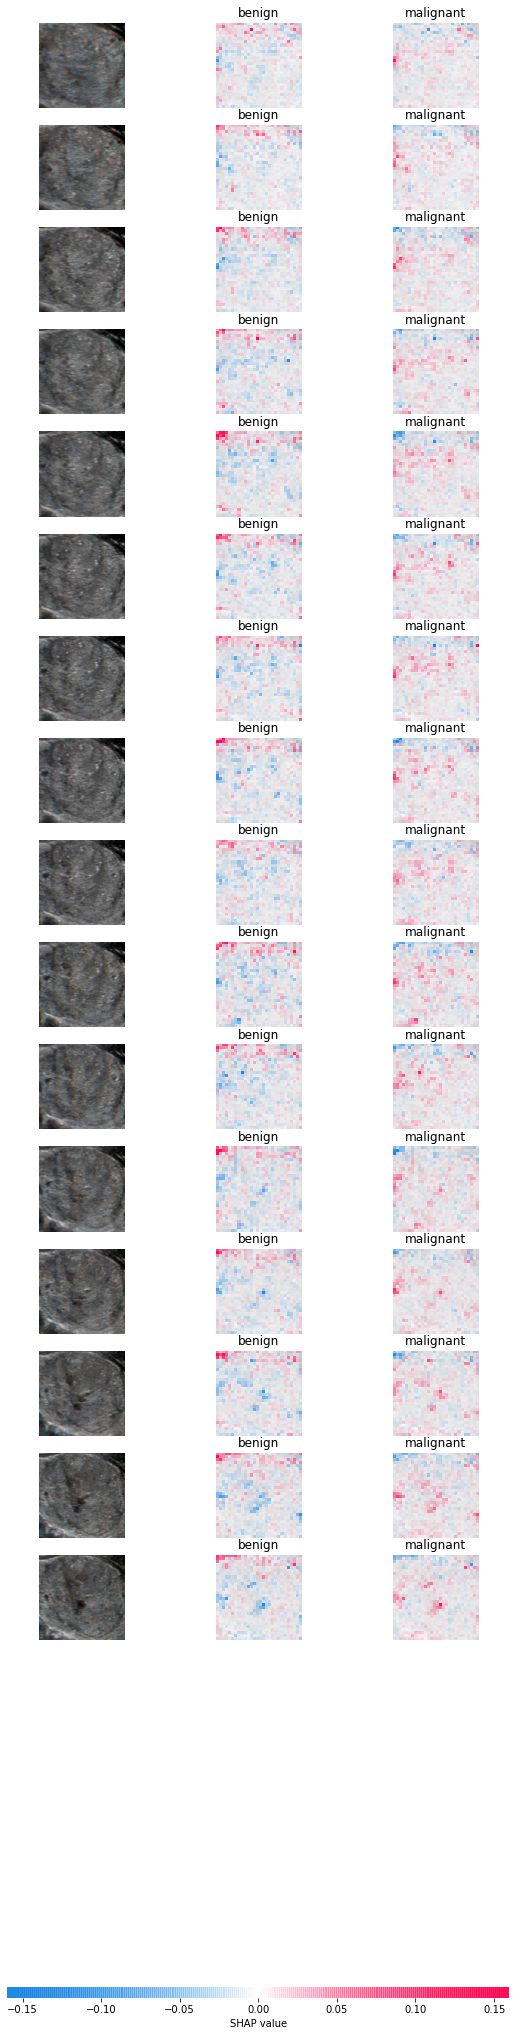

starting shap


true class: 1     patient 183_
predicted probabilities [0.00061665 0.00087756 0.00096107 0.00080764 0.0017065  0.00290733
 0.00019592 0.00058066 0.00010067 0.00045535 0.00012027 0.00300641
 0.00675495 0.00162377 0.00036931 0.00061169]


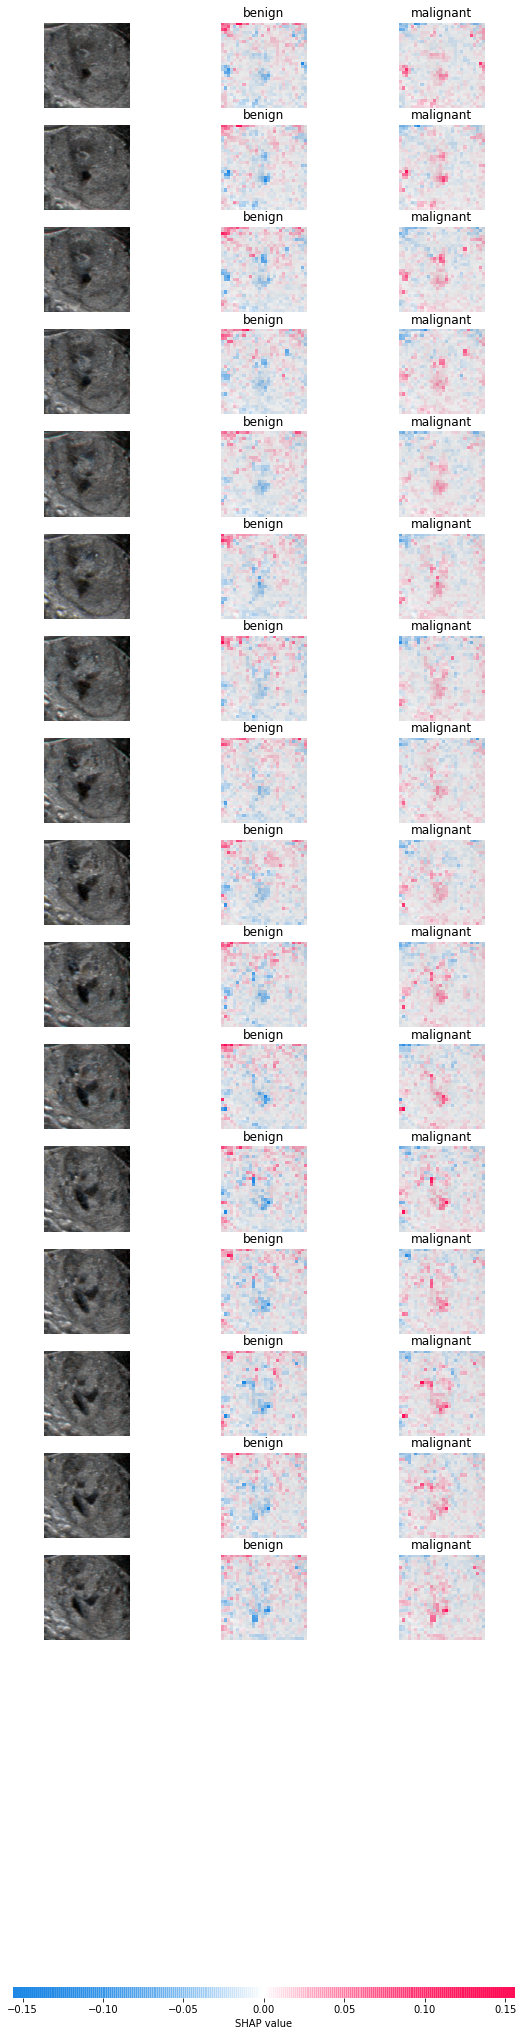

starting shap


true class: 1     patient 183_
predicted probabilities [0.00443491 0.00696565 0.01189778 0.00608113 0.02743169 0.03235457
 0.05523473 0.0347168  0.01377761 0.02572704 0.00916207 0.16727877
 0.04534272 0.11209323 0.06768026 0.05949132]


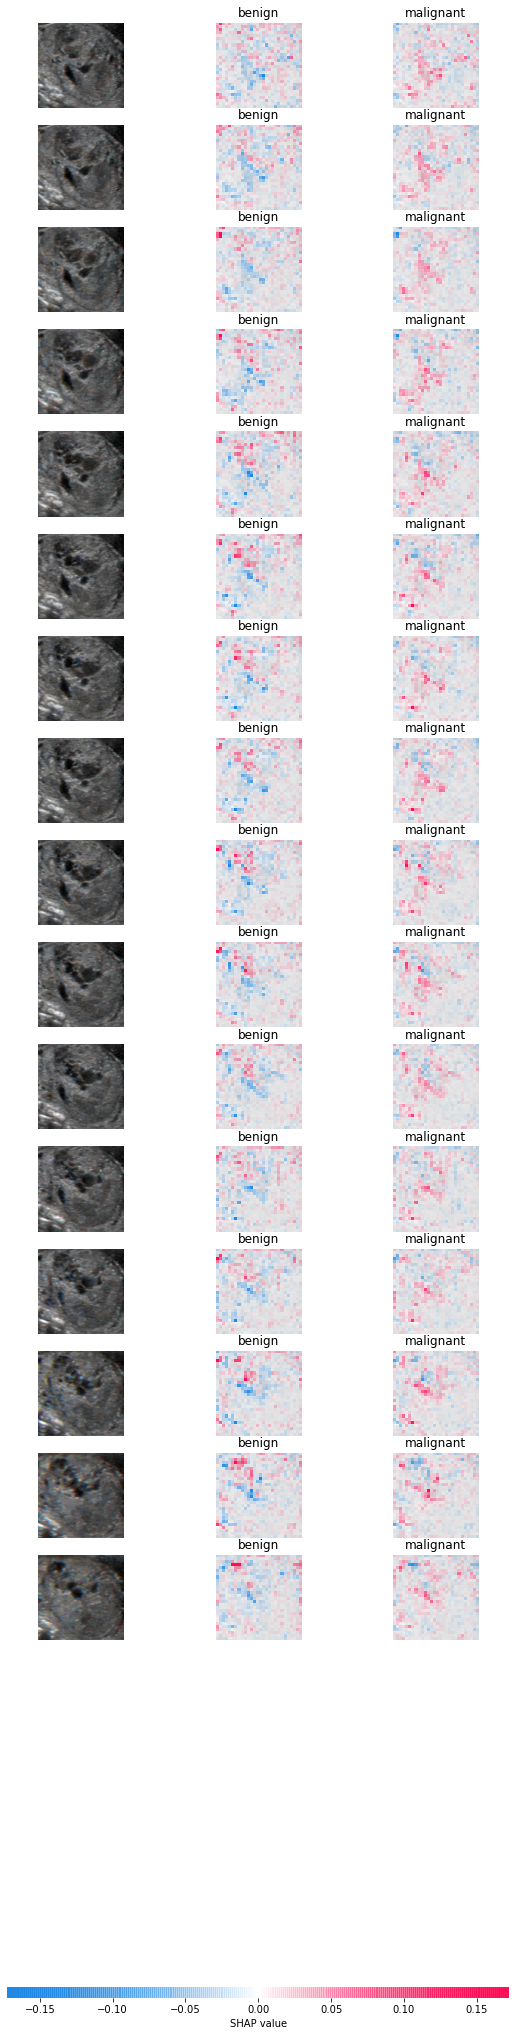

starting shap


true class: 1     patient 183_
predicted probabilities [1.39045045e-02 1.03711225e-02 1.15402397e-02 9.83134098e-03
 4.63077752e-03 1.25727765e-02 5.86889312e-03 4.99920628e-04
 5.22519089e-02 1.50863742e-02 6.69575809e-03 1.63815479e-04
 7.41902040e-05 1.51130173e-03 4.44717612e-03 6.87605282e-03]


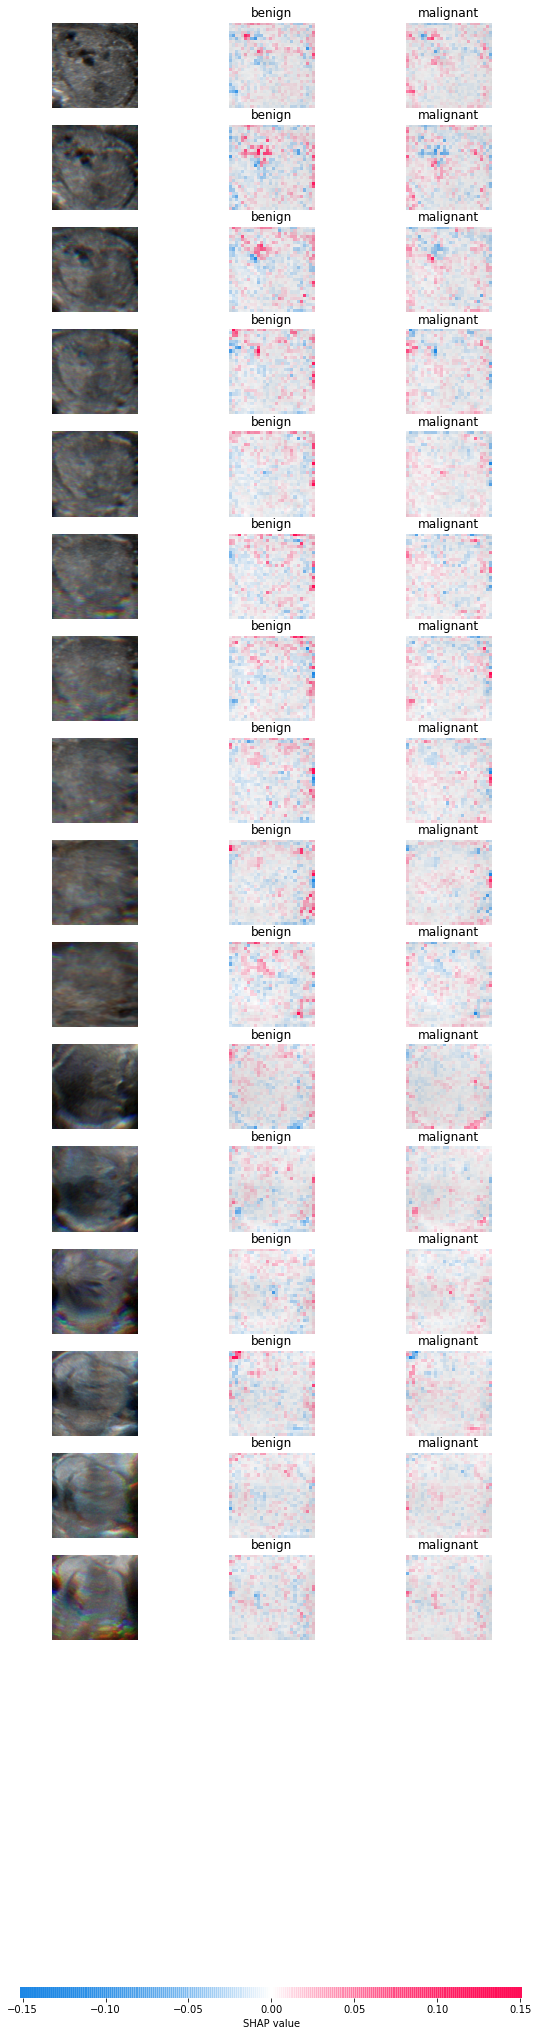

starting shap


true class: 1     patient 15_
predicted probabilities [0.77368385 0.98952407 0.52046436 0.49850515 0.95072705 0.8769411
 0.8377832  0.4690351  0.10622164 0.6839339  0.13692284 0.41237026
 0.931809   0.98648304 0.97227174 0.89879525]


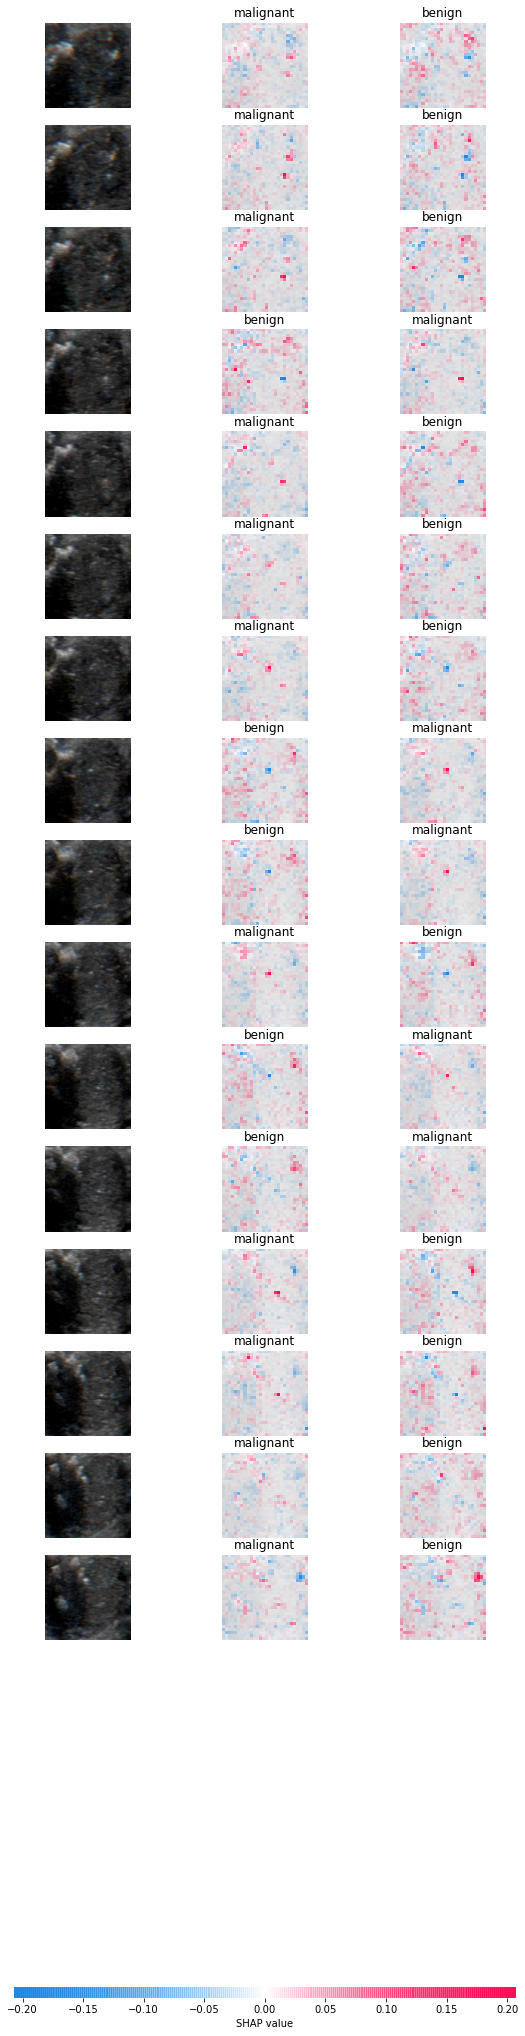

starting shap


true class: 1     patient 15_
predicted probabilities [0.24143529 0.53324974 0.4146459  0.3556087  0.7964728  0.7879266
 0.91635615 0.32389504 0.24247898 0.66356206 0.53668123 0.6210092
 0.3403973  0.00702565 0.00791815 0.02304051]


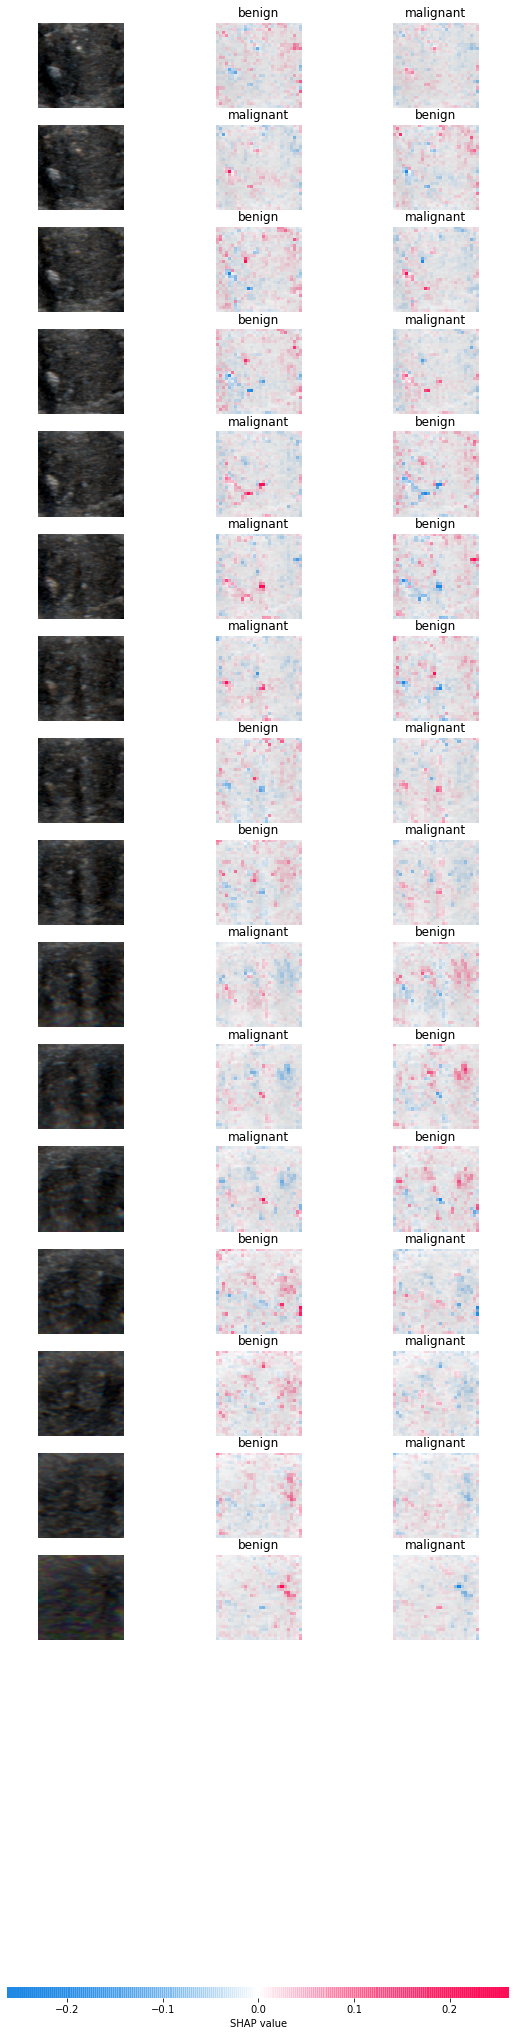

starting shap


true class: 1     patient 15_
predicted probabilities [0.36906466 0.3236077  0.06609975 0.08045411 0.77254164 0.9490466
 0.95994633 0.96311176 0.72845227 0.68660367 0.9598816  0.9660836
 0.9982091  0.9974853  0.997973   0.21680358]


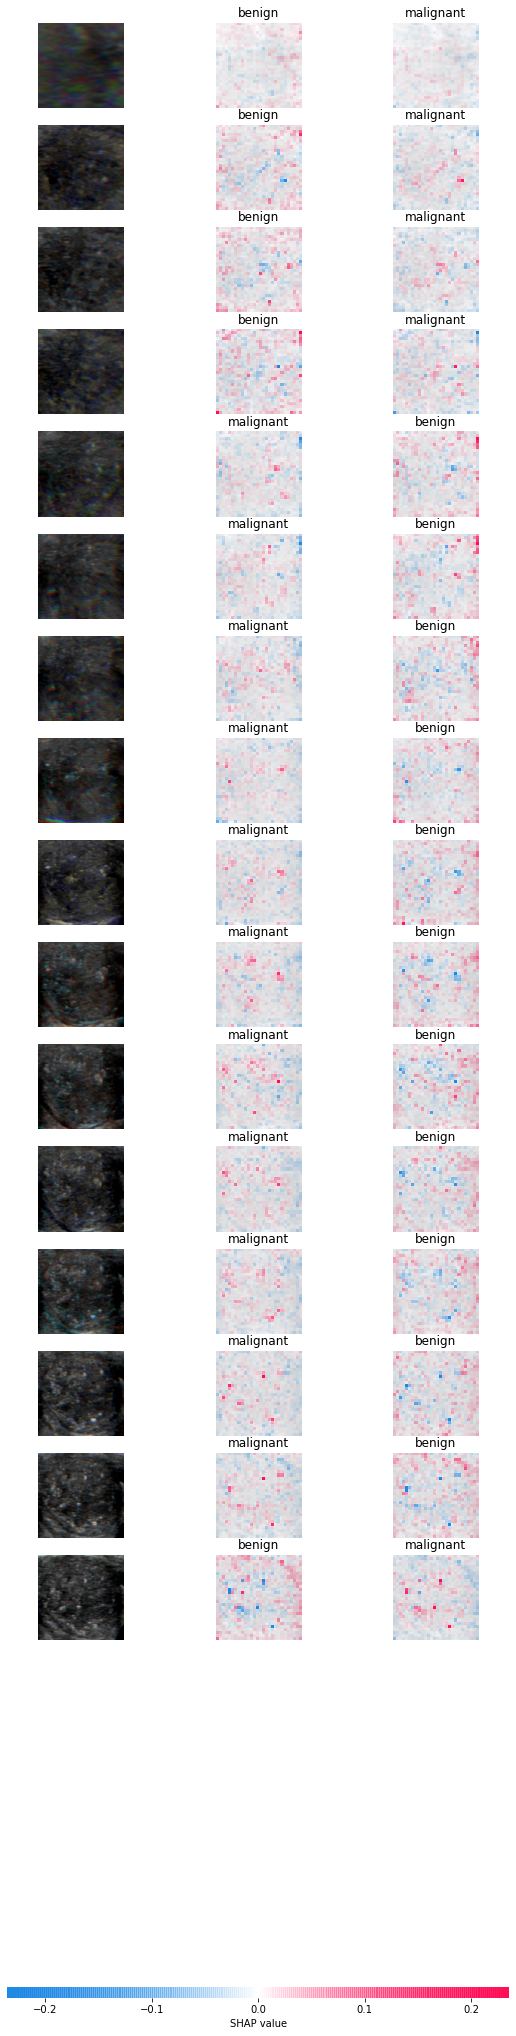

starting shap


true class: 1     patient 171_
predicted probabilities [0.8962743  0.9655119  0.9904083  0.9322331  0.9088754  0.94364077
 0.8590903  0.61271584 0.11768537 0.9684941  0.90753293 0.9674106
 0.9776613  0.5590992  0.7706777  0.0143449 ]


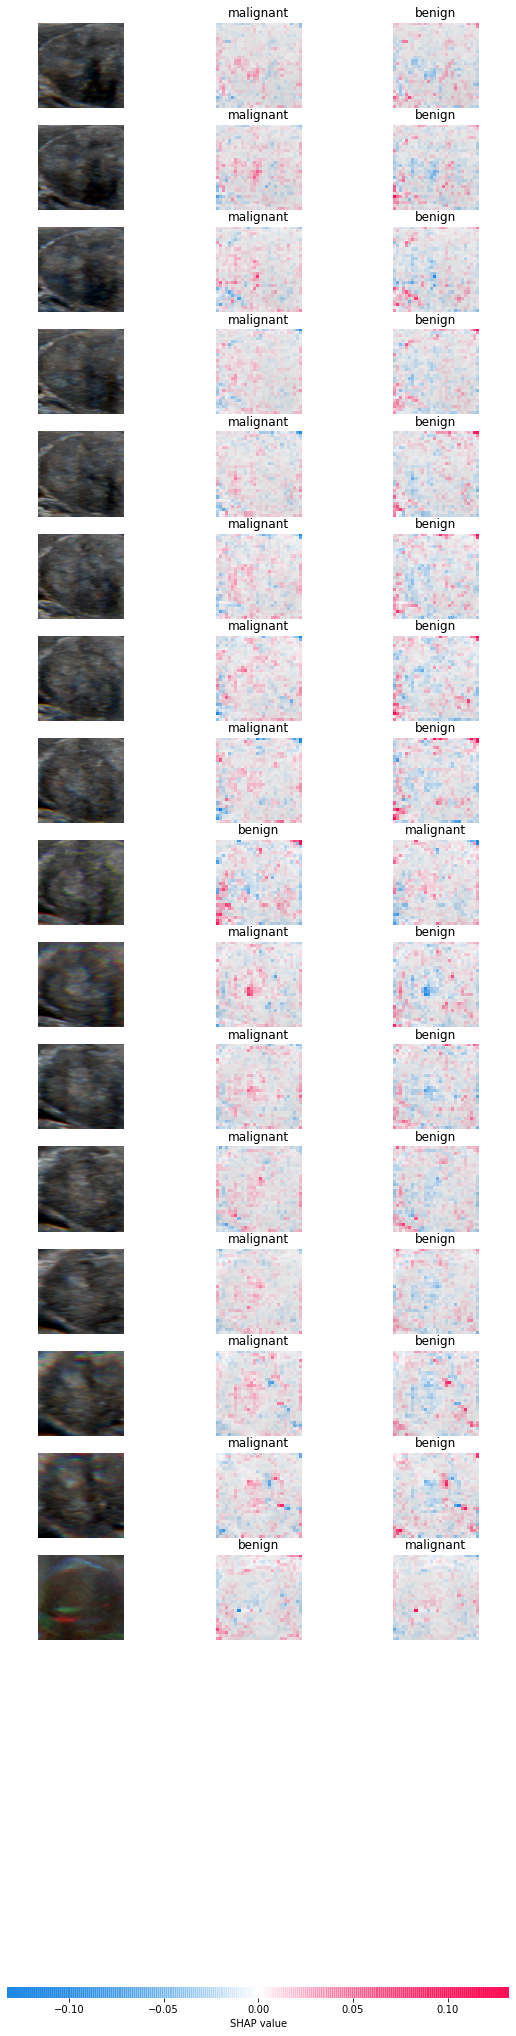

197_ 0.0 0.0005779581260867417
183_ 1.0 0.0002566301263868809
11_ 0.0 0.0311517883092165
55_ 0.0 0.05493374541401863
30_ 0.0 0.004993164911866188
124_ 0.0 0.0015746407443657517


In [237]:
#load test data
args.cvphase = 2
epochs = [72, 60, 88, 94, 61]
args.best_epoch = epochs[args.cvphase]
print(args.cvphase)
#args.best_epoch = 87
print(args.best_epoch)
print("TEST: cv phase", args.cvphase)

args.frametype = "adjacent"

test_set = DatasetThyroid3StackedNew("test", args.cvphase, args.frametype, imgs, largestpatinds, transform=transformNorm)
test_model(args.best_epoch, 5)
